# Public notebook on the usage of higher order Stencils in the Jacobi and SOR method, as well as extras

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
""" Remove the quotation marks '' and run only if following dependencies are not installed.

pip install numpy
pip install Cython
pip install matplotlib"""

" Remove the quotation marks '' and run only if following dependencies are not installed.\n\npip install numpy\npip install Cython\npip install matplotlib"

In [3]:
%load_ext Cython

In [22]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
cimport cython
from cython.parallel import prange
cimport numpy as np
import operator
from libc.math cimport sqrt
from libc.math cimport pi

ctypedef np.float32_t dtype_t




""" Iterative Methods. Jacobi and SOR . !!!: Following methods use the 8-stenicl (8 nearest neighbour interaction)"""

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cdef void jacobi_iteration(int n, int m, dtype_t[:,:] new_array, dtype_t[:,:] old_array, dtype_t[:,:] mask) nogil:
    cdef size_t i, j
    cdef double tmp
    for i in prange(1, n-1, nogil=True):
        for j in prange(1, m-1):
            if not mask[i, j]:
                new_array[i, j] = 0.2*(old_array[i-1,j]+old_array[i+1,j]+old_array[i,j-1]+old_array[i,j+1]) + \
                0.05*(old_array[i+1,j+1]+old_array[i+1,j-1]+old_array[i-1,j+1]+old_array[i-1,j-1])


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cpdef tuple jacobi_fx(dtype_t[:,:] A, dtype_t[:,:] mask, int max_iterations, dtype_t error):
    cdef int i, n, m, iteration
    cdef double norm, norm_prev, tmp_error
    n = A.shape[0]
    m = A.shape[1]
    cdef dtype_t[:,:] new_arr = A.copy()
    cdef dtype_t[:,:] old_arr = A.copy()
    norm_prev = 0
    norm = 0
    iteration = 0
    for i in range(max_iterations):
        norm = np.linalg.norm(old_arr)
        jacobi_iteration(n, m, new_arr, old_arr, mask)
        old_arr = new_arr
        tmp_error = abs(norm - norm_prev)
        norm_prev = norm
        iteration = iteration + 1
        if tmp_error < error:
            break
    return (new_arr, tmp_error, iteration)




@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cdef void sor(int n, int m, dtype_t[:,:] GS_arr, dtype_t[:,:] mask, dtype_t alpha) nogil:
    cdef size_t i "xmm1"
    cdef size_t j "xmm2"
    for i in prange(1, n-1, nogil=True):
        for j in prange(1, m-1):
            if not mask[i, j]:
                GS_arr[i,j] = (1-alpha)*GS_arr[i,j] + 0.2*alpha*(GS_arr[i+1,j]+GS_arr[i,j+1]+GS_arr[i-1,j]+GS_arr[i,j-1]) + \
                0.05*alpha*(GS_arr[i+1,j+1] + GS_arr[i+1,j-1] + GS_arr[i-1,j+1] + GS_arr[i-1,j-1])


                    
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
@cython.cdivision(True)
cpdef tuple sor_fx(dtype_t[:,:] A, dtype_t[:,:] mask, int max_iterations, dtype_t error, dtype_t alpha):
    cdef int n, m, iteration
    cdef double norm "xmm3"
    cdef double norm_prev "xmm4"
    cdef double tmp_error "xmm5"
    cdef size_t i "xmm6"
    norm_prev = 0
    norm = 0
    iteration = 0
    n = A.shape[0]
    m = A.shape[1]
    cdef dtype_t[:,:] GS_matrix = A.copy()
    alpha_ideal = 1.976/(1+(pi/sqrt(n*m)))
    if alpha == 0:
        alpha = alpha_ideal
    for i in range(max_iterations):
        norm = np.linalg.norm(GS_matrix)
        sor(n, m, GS_matrix, mask, alpha)
        tmp_error = abs(norm - norm_prev)
        norm_prev = norm
        iteration = iteration + 1
        if tmp_error < error:
            break
    return (GS_matrix, tmp_error, iteration)
                                                                                                

    
    
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cpdef tuple up_cycle(dtype_t [:,:] potential, dtype_t[:,:] mask, int total_samples, int inner_iterations, dtype_t convergance, dtype_t index_truncation_factor):
    

    cdef list sample_masks = []
    cdef list modifiable_potential = []
    cdef list data = []
    cdef int number, length, pot_count
    

    modifiable_potential.append(coarsen_potential(potential, index_truncation_factor*(1/total_samples)))
    sample_masks.append(mask)
    

    for number in range(total_samples):
        sample_masks.append(coarsen_potential(mask, index_truncation_factor*(1/(number+1))))
        
    length = len(sample_masks) - 1
    pot_count = 0
    
    while length>=0:
        set_dirichlet(modifiable_potential[pot_count], sample_masks[length])


        result = sor_fx(modifiable_potential[pot_count], sample_masks[length], inner_iterations, convergance, 0.0)
        
        if length>0:
            modifiable_potential.append(interpolate_potential(result[0], sample_masks[length-1].shape[0], sample_masks[length-1].shape[1]))
            data.append(result[1])
            data.append(result[2])
        
        length = length-1
        
        pot_count = pot_count +1
    return modifiable_potential, data


""" Boundary Condition handeling methods """
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cdef void set_dirichlet(dtype_t[:,:] array, dtype_t[:,:] mask) nogil:
    cdef size_t i, j
    cdef int rows = array.shape[0]
    cdef int cols = array.shape[1]
    for i in range(rows):
        for j in range(cols):
            if mask[i, j]:
                array[i, j] = mask[i, j]                                                                                                
                                                                                                

        
""" Index projection methods """
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cdef dtype_t[:, :] coarsen_potential(dtype_t[:, :] potential, dtype_t index_truncation_factor):
    cdef int rows, cols, i, j, inv
    rows = <int>(potential.shape[0] * index_truncation_factor)
    cols = <int>(potential.shape[1] * index_truncation_factor)
    cdef dtype_t[:,:] coarsened_potential = np.zeros((rows, cols), dtype=np.float32)
    inv = <int>(1 / index_truncation_factor)
    for i in range(rows):
        for j in range(cols):
            coarsened_potential[i, j] = np.mean(potential[i * inv:i * inv + inv, j * inv:j * inv + inv])
    return coarsened_potential




@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cdef dtype_t[:, :] interpolate_potential(dtype_t[:, :] potential, int target_height, int target_width):

    cdef dtype_t[:, :] smoothed_potential
    smoothed_potential = np.zeros((target_height, target_width), dtype=np.float32)

    cdef int i, j, ii, jj
    cdef dtype_t height_ratio, width_ratio
    height_ratio = potential.shape[0] / target_height
    width_ratio = potential.shape[1] / target_width

    for i in range(target_height):
        for j in range(target_width):
            ii = <int>(i * height_ratio)
            jj = <int>(j * width_ratio)
            smoothed_potential[i, j] = potential[ii, jj]
    return smoothed_potential



""" Methods to Create primitive Shapes with index algebra """

operators = {'>': operator.gt,
        '<': operator.lt,
        '>=': operator.ge,
        '<=': operator.le,
             '==': operator.eq}


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cpdef void create_circle(dtype_t[:,:] matrix, dtype_t[:,:] mask, dtype_t x, dtype_t y, dtype_t radius, dtype_t value, dtype_t m_value, str param):
    cdef int i, j
    cdef int rows = matrix.shape[0]
    cdef int cols = matrix.shape[1]
    for i in range(rows):
        for j in range(cols):
            if operators[param](((i-y)*(i-y) + (j-x)*(j-x)), radius*radius):
                matrix[i, j] = value
                mask[i, j] = m_value

                
                
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cpdef void create_rectangle(dtype_t[:,:] matrix, dtype_t[:,:] mask, dtype_t x, dtype_t y, dtype_t width, dtype_t height, dtype_t value, dtype_t m_value, str param):
    cdef int i, j
    cdef int rows = matrix.shape[0]
    cdef int cols = matrix.shape[1]
    cdef double left = x - width / 2
    cdef double right = x + width / 2
    cdef double top = y - height / 2
    cdef double bottom = y + height / 2
    for i in range(rows):
        for j in range(cols):
            if operators[param](left, j) and operators[param](j, right) and operators[param](top, i) and operators[param](i, bottom):
                matrix[i, j] = value
                mask[i, j] = m_value

             
            


In [15]:
res = (2160, 3840)
potential = np.zeros(res, dtype=np.float32) 
mask = np.zeros(res, dtype=np.float32)
"""The names 'potential' and 'mask' are variables that go into the keyword arguments of functions like create_circle or create_rectangle """

"""Optional variables"""
"""!!Check if in usage. Probably so!!"""

center_y, center_x = potential.shape[0]//2, potential.shape[1]//2
radius = 1000
hollow_radius = 800
small_radius = 600


"""Let's put the boundary conditions"""
create_circle(potential, mask, center_x, center_y, radius, 100, 100, '<=')
create_circle(potential, mask, center_x, center_y, hollow_radius, 0., 0, '<=')
create_circle(potential, mask, center_x, center_y, small_radius, -100., -100, '<=')
create_rectangle(potential, mask, center_x, center_y, 150, 1250, 0., 0, '<=')
create_rectangle(potential, mask, center_x, center_y, 1250, 150, 0., 0, '<=')
create_rectangle(potential, mask, center_x*0.5-350, center_y, 200, 1980, -100, -100, '<=')
create_rectangle(potential, mask, center_x*1.5+350, center_y, 200, 1980, -100., -100, '<=')
create_circle(potential, mask, center_x, center_y, 30, -100, -100, '<=')
create_circle(potential, mask, center_x+200, center_y, 30, 120, 120, '<=')
create_circle(potential, mask, center_x-200, center_y, 30, 120, 120, '<=')
create_circle(potential, mask, center_x, center_y+200, 30, 120, 120, '<=')
create_circle(potential, mask, center_x, center_y-200, 30, 120, 120, '<=')
create_circle(potential, mask, center_x+400, center_y, 30, 120, 120, '<=')
create_circle(potential, mask, center_x-400, center_y, 30, 120, 120, '<=')
create_circle(potential, mask, center_x, center_y+400, 30, 120, 120, '<=')
create_circle(potential, mask, center_x, center_y-400, 30, 120, 120, '<=')

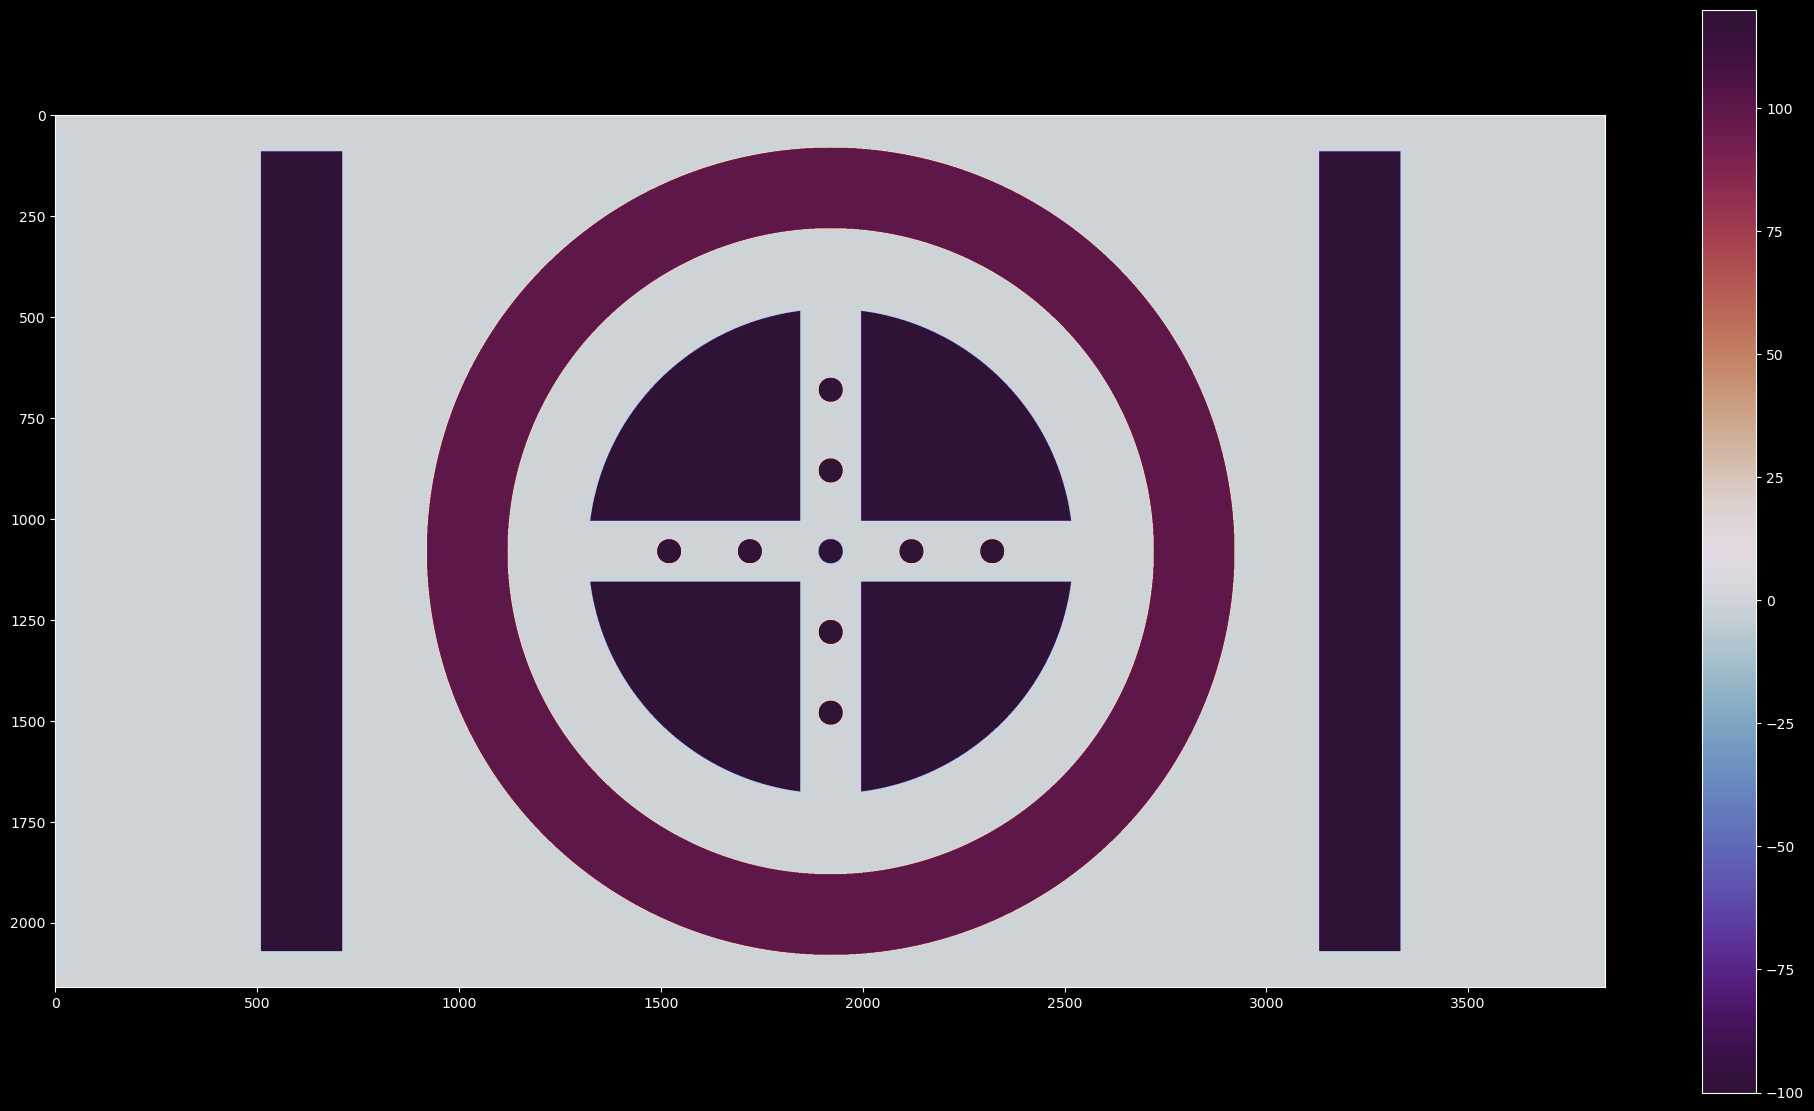

In [16]:
plt.figure(figsize=(25, 14.0625))
plt.imshow(potential, cmap='twilight_shifted')
plt.colorbar()

In [17]:
%%time
result = sor_fx(potential, mask, 50000, 0.001, 0)

Wall time: 2min 12s


In [18]:
result[1]

0.0

In [20]:
print(f"{result}\nAchieved error: {result[1]}\nRequired iterations: {result[2]}\nFinal Array L2-norm: {np.linalg.norm(result[0])}\nArray size in MB: {result[0].nbytes*1e-6} MegaBytes")

(<MemoryView of 'array' at 0x1cc2c675080>, 0.0, 3726)
Achieved error: 0.0
Required iterations: 3726
Final Array L2-norm: 208822.53125
Array size in MB: 33.1776 MegaBytes


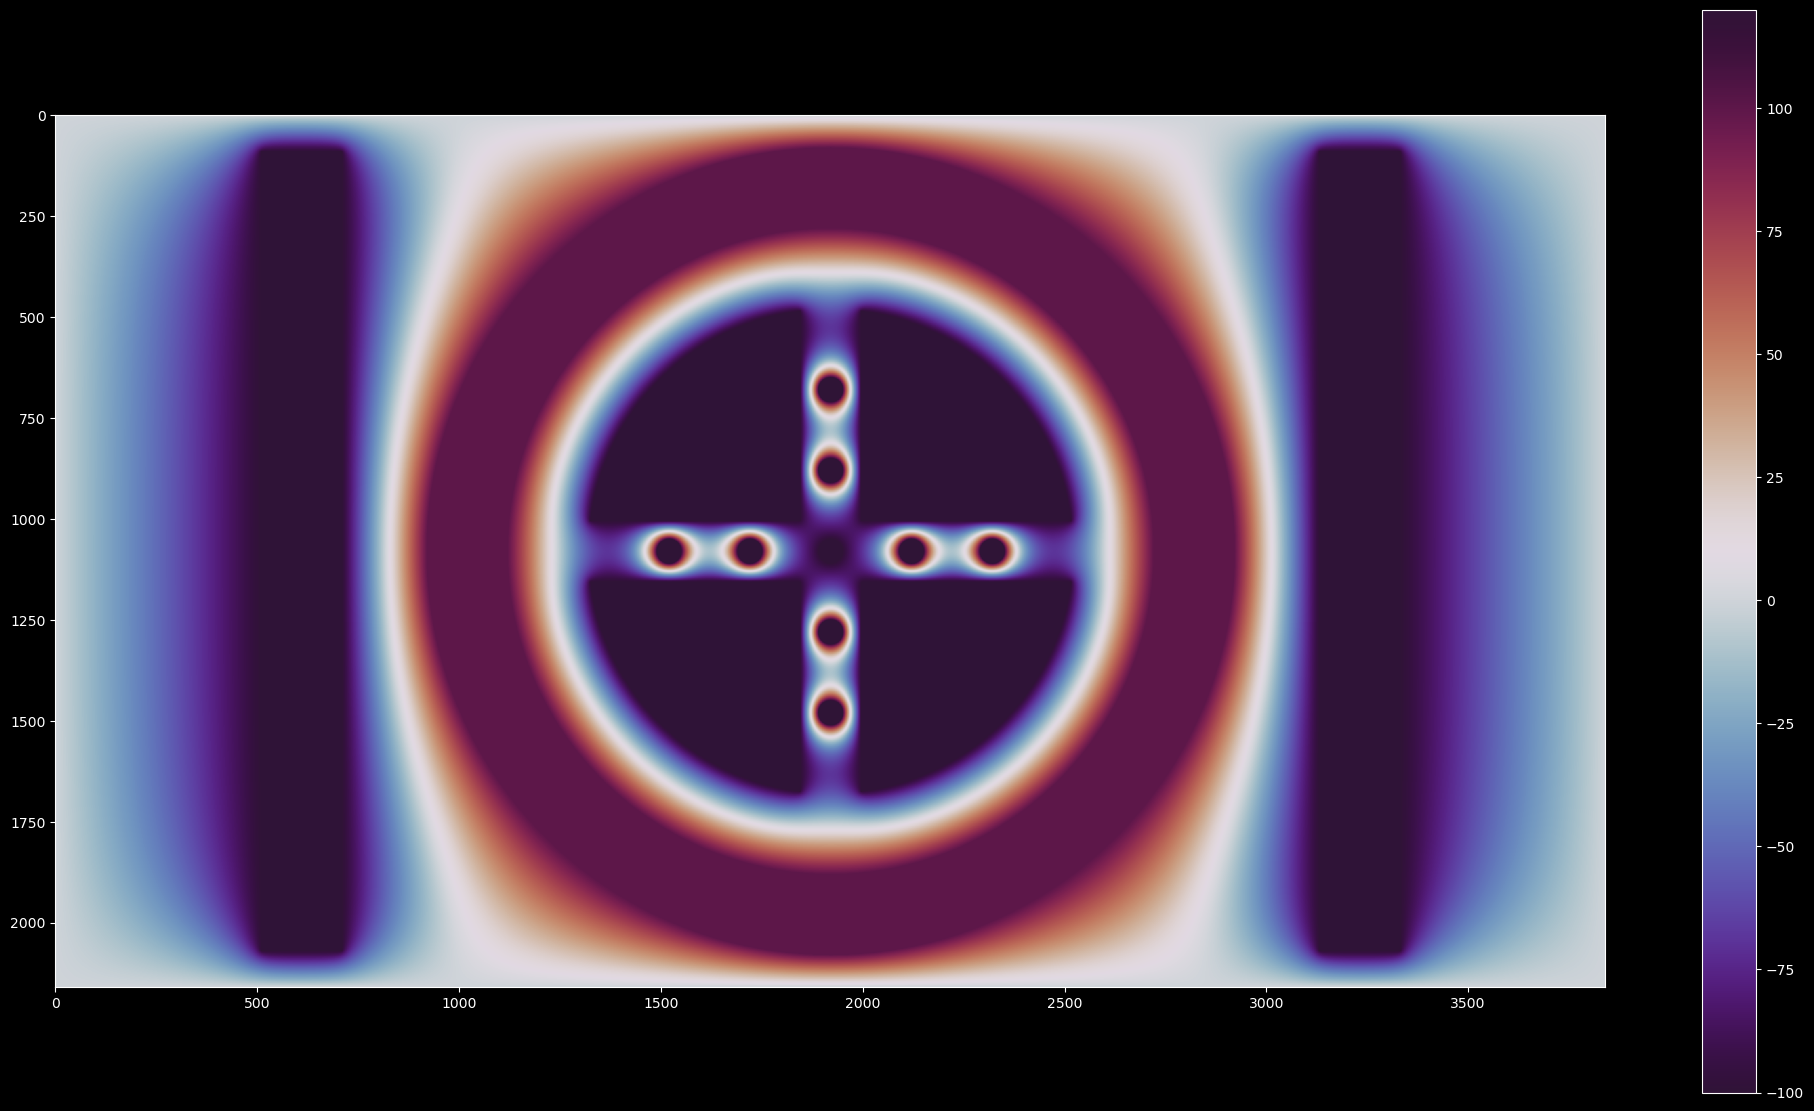

In [21]:
plt.figure(figsize=(25, 14.0625))
plt.imshow(result[0], interpolation='none', cmap='twilight_shifted')
plt.colorbar()

In [ ]:
#run to save as desktop bg. 
"""
you can set cmap = '...' for more interesting graphs
'hsv'
'gnuplot'
'gnuplot2'
'viridis'
'plasma'
'inferno'
'spring'
'copper'
'gist_rainbow'
'binary'
"""
plt.imsave('name.png', result[0], cmap='twilight_shifted', dpi=240)

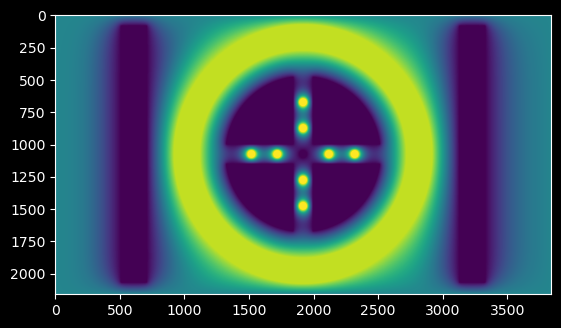

In [11]:

potential = result[0]
plt.imshow(potential)


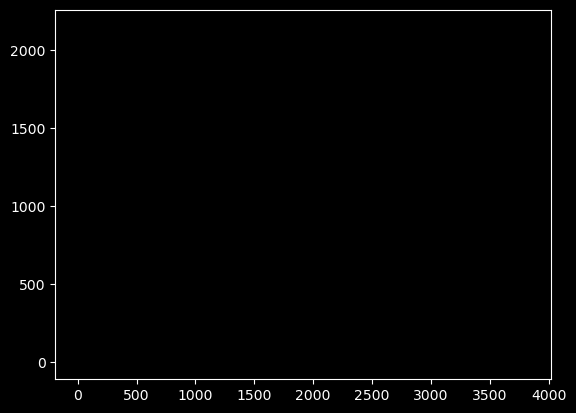

In [12]:
# Compute the gradient of the potential
grad_y, grad_x = np.gradient(potential)

# Subsample the gradient arrays
subsample = 10
grad_x = grad_x[::subsample, ::subsample]
grad_y = grad_y[::subsample, ::subsample]

# Create a grid of x and y coordinates for plotting the quiver plot
x = np.arange(0, potential.shape[1], subsample)
y = np.arange(0, potential.shape[0], subsample)
X, Y = np.meshgrid(x, y, indexing='ij')

# Plot the quiver plot of the vector field
plt.quiver(X, Y, grad_x, grad_y)
plt.show()

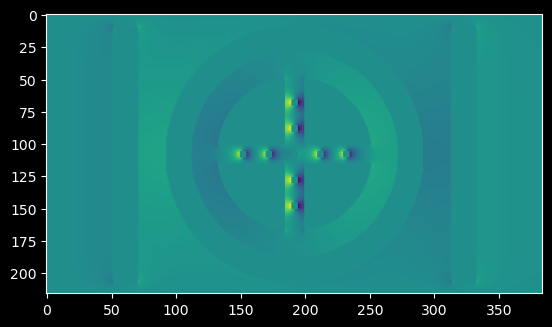

In [15]:
plt.imshow(grad_x)

In [ ]:
"""
more interesting boundaries on the edges ^_^
testside = np.linspace(0.0, 8*np.pi, num=res[0])
testup = np.linspace(0.0, 8*np.pi, num=res[1])

potential[:,0]=35*(np.cos(2*testside))
potential[:,-1]=35*(np.cos(2*testside))
potential[0,:]=35*(np.cos(2*testup))
potential[-1,:]=35*(np.cos(2*testup))


import pygame

# Define the size of the window
WINDOW_SIZE = (1920, 1080)

# Create the Pygame window
pygame.init()
screen = pygame.display.set_mode(WINDOW_SIZE)
pygame.display.set_caption("Potential")

# Define some colors
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)

# Define a color map to improve the color scheme
color_map = [(0, 0, 255 * i // 256) for i in range(256)]

# Start the main loop
running = True
while running:
    # Handle events
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    # Update the potential array
    jacobi_iteration(potential, mask)

    # Create a surface from the potential array
    surface = pygame.surfarray.make_surface(np.rot90(potential, k=1))
    surface.set_palette(color_map)

    # Scale the surface to fit the screen
    surface = pygame.transform.scale(surface, WINDOW_SIZE)

    # Draw the surface on the screen
    screen.blit(surface, (0, 0))

    # Update the screen
    pygame.display.flip()

# Quit Pygame when the main loop exits
pygame.quit()

"""